<a href="https://colab.research.google.com/github/Githubmany/Projects/blob/master/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning  feature extraction, now `it's time to learn about a new kind of transfer learning: fine-tuning.

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-04 23:05:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-04 23:05:20 (87.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note** If you;re running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want to access your helper functions.

## Let's get some data

This time we are going to see if we can use pretrained models within `tf.keras.applications` and apply htem to our own problem (recognizing images of food).
link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-06-04 23:05:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  93.8MB/s    in 1.7s    

2024-06-04 23:05:27 (93.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 14.          10.           7.        ]
   [ 14.          10.           7.        ]
   [ 14.          10.           7.        ]
   ...
   [ 45.93878     22.938782    16.938782  ]
   [ 45.954075    22.954073    16.954073  ]
   [ 44.714287    21.714285    15.714286  ]]

  [[ 14.          10.           7.        ]
   [ 14.          10.           7.        ]
   [ 14.          10.           7.        ]
   ...
   [ 46.142834    23.142836    17.142836  ]
   [ 44.862247    21.862246    15.862246  ]
   [ 45.954082    22.954084    16.954084  ]]

  [[ 14.785714    10.           7.        ]
   [ 14.785714    10.           7.        ]
   [ 14.785714    10.           7.        ]
   ...
   [ 45.214264    22.214264    16.214264  ]
   [ 43.80102     20.801023    14.8010235 ]
   [ 45.86225     22.862253    16.862253  ]]

  ...

  [[248.5051     252.5051     253.5051    ]
   [249.9847     253.9847     254.9847    ]
   [251.04591    255.         254.83163   ]
   ...
   [240.04095    242.331

## Model 0 : Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight forward, it runs our layers in sequential order.
But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create base model  with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

In [ ]:
# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

In [ ]:
# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to dor EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

In [ ]:
# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

Shape after passing inputs through base model: (None, 7, 7, 1280)


In [ ]:
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])


Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240604-230539
Epoch 1/5
24/24 [==============================] - 20s 357ms/step - loss: 1.8942 - accuracy: 0.4107 - val_loss: 1.3029 - val_accuracy: 0.7451
Epoch 2/5
24/24 [==============================] - 5s 184ms/step - loss: 1.1003 - accuracy: 0.7680 - val_loss: 0.8679 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 3s 128ms/step - loss: 0.7914 - accuracy: 0.8160 - val_loss: 0.6866 - val_accuracy: 0.8586
Epoch 4/5
24/24 [==============================] - 5s 187ms/step - loss: 0.6426 - accuracy: 0.8507 - val_loss: 0.6025 - val_accuracy: 0.8766
Epoch 5/5
24/24 [==============================] - 4s 134ms/step - loss: 0.5533 - accuracy: 0.8787 - val_loss: 0.5428 - val_accuracy: 0.8701


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.5595 - accuracy: 0.8596


[0.559545636177063, 0.8596000075340271]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

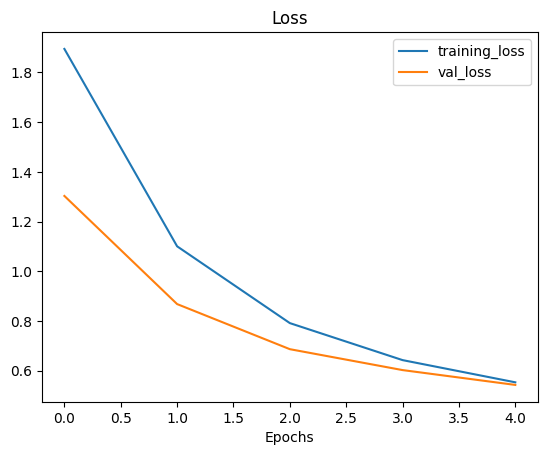

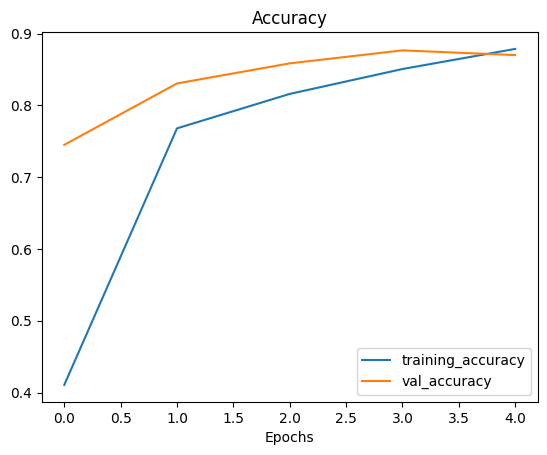

In [ ]:
# Check out our model' training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

In [ ]:
# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [ ]:
# Pass the random tensor through a global average poolingn2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [ ]:
# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 🛠 **Practice:** Try to to do the same with the above two cells but this time use `GlobalMaxPool2D`...and see what happens.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the |tf.keras.layers.GlobalAveragePool2D()|layer) which can be used to extract patterns out of our own soecific problem.

```
# This is formatted as code
```



## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`  - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** through out all experiments the same test dataset will be used to evaluate our mdel... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-06-04 23:06:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   112MB/s    in 1.1s    

2024-06-04 23:06:32 (112 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create  training and test data
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=32)  # default)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

WE can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://wwww.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image and data augmentation only happens during training, so we can still export our model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import  preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
# preprocessing.Rescale(1./255) # Keep for model like ResNet50V2 but EfficientNet's having rescaling built in
], name="data_augmentation")

## Visualize our data augmentation layer (and see what happens to our data)



tf.Tensor(
[[[159.99997  155.21933  136.08281 ]
  [158.45944  154.94489  137.1605  ]
  [158.76097  156.40544  141.00092 ]
  ...
  [141.30128  125.30129   92.30129 ]
  [144.03322  128.03322   95.03321 ]
  [145.11707  128.90137   96.548454]]

 [[159.8611   154.91425  135.57452 ]
  [158.80518  154.8607   136.969   ]
  [158.17424  155.90706  140.4238  ]
  ...
  [141.48561  125.4856    92.4856  ]
  [142.77043  126.76449   93.782326]
  [142.66034  126.289734  94.401535]]

 [[160.41904  155.44075  136.15117 ]
  [159.55797  155.23555  136.7298  ]
  [158.24515  155.70168  139.15543 ]
  ...
  [143.35696  127.35695   94.35695 ]
  [143.2958   127.224884  94.437645]
  [141.88531  125.295334  94.0653  ]]

 ...

 [[159.00534  186.95541  241.1242  ]
  [160.64972  186.07709  242.7483  ]
  [160.06024  186.05698  242.92957 ]
  ...
  [122.350746 126.893745 131.29951 ]
  [121.98161  128.32413  133.68333 ]
  [121.89581  128.72607  134.63228 ]]

 [[159.48961  186.34383  241.73723 ]
  [160.82864  186.0081   2

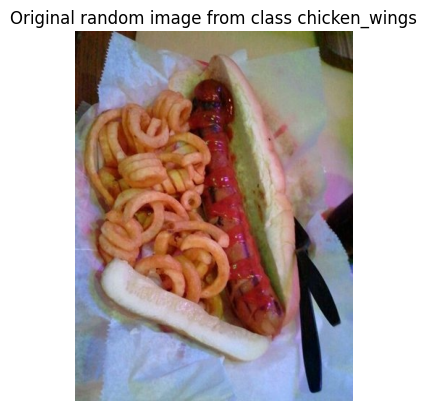

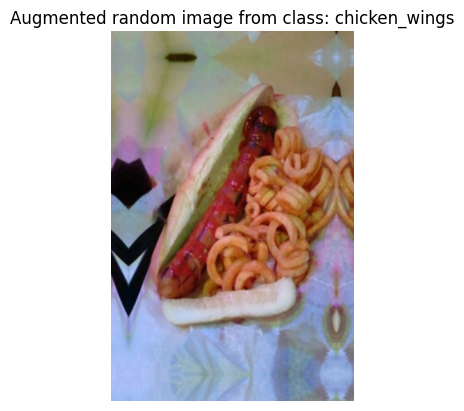

In [ ]:
# View a random image and compare it to its augmented version
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
print(augmented_img)




## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240604-230638
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3859 - accuracy: 0.1571 - val_loss: 2.1617 - val_accuracy: 0.2533
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1090 - accuracy: 0.2429 - val_loss: 2.0284 - val_accuracy: 0.3240
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9291 - accuracy: 0.3429 - val_loss: 1.9285 - val_accuracy: 0.3832
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7287 - accuracy: 0.6143 - val_loss: 1.8352 - val_accuracy: 0.4490
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5898 - accuracy: 0.6143 - val_loss: 1.7211 - val_accuracy: 0.5181


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 5s 62ms/step - loss: 1.7176 - accuracy: 0.5256


[1.717621088027954, 0.525600016117096]

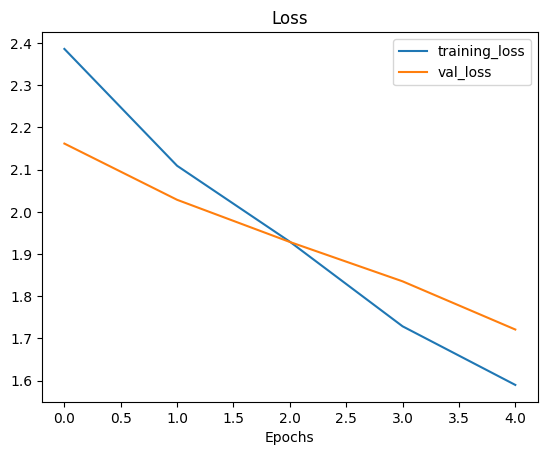

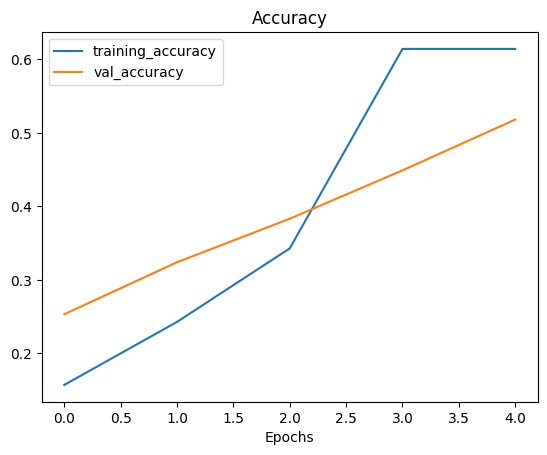

In [ ]:
# How does the model with 1% of  the data and augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of the data and data augmentation

In [ ]:
# Get 10% of data.... (incomment if you don't have it)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!unzip 10_food_classes_10_percent.zip
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"



--2024-06-04 23:07:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  77.0MB/s    in 2.1s    

2024-06-04 23:07:29 (77.0 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]

Archive:  10_food_classes_10_percent.zip
replace __MACOSX/._10_food_classes_10_percent? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Set data inputs
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent_ = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent, # Use the original directory path
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # if you are using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in
], name="data_augmentation")

In [ ]:
# Setup the image shape to our model
input_shape = (224,224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentaion doesn't occur on test data)
x = base_model(x,training=False) # pass augmented images to base model but keep it in inference mode (weights don't get updated and training is turned off for them), this also insures batchnorm layers don't get updated.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=False,
                                                          save_freq="epoch",  #save every epoch
                                                          verbose=1)

## Fit model_2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240604-230759
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9319 - accuracy: 0.3613
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 33s 1s/step - loss: 1.9319 - accuracy: 0.3613 - val_loss: 1.3760 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2797 - accuracy: 0.6787
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 820ms/step - loss: 1.2797 - accuracy: 0.6787 - val_loss: 0.9569 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9995 - accuracy: 0.7480
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 747ms/step - loss: 0.9995 - accuracy: 0.7480 - val_loss: 0.7489 - val_accuracy: 0.8076
Epoc

In [ ]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.5595 - accuracy: 0.8596


[0.5595455765724182, 0.8596000075340271]

In [ ]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 65ms/step - loss: 0.6180 - accuracy: 0.8424


[0.6179946064949036, 0.8424000144004822]

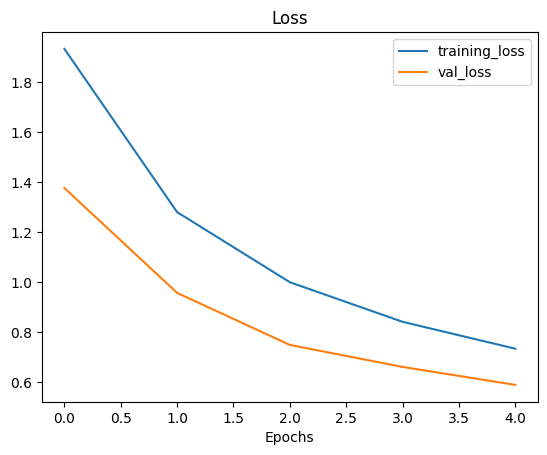

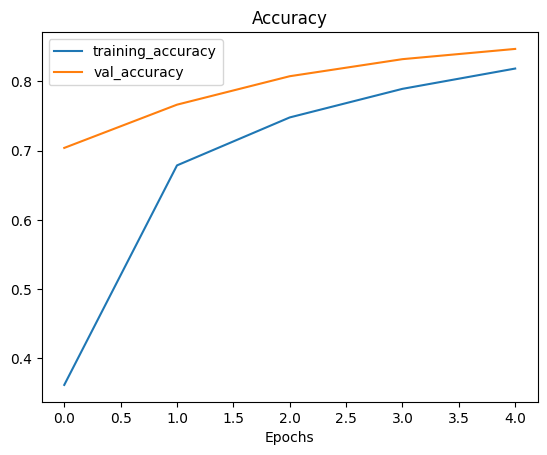

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

## Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.6180 - accuracy: 0.8424


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

True

In [ ]:
results_10_percent_data_aug

[0.6179946064949036, 0.8424000144004822]

In [ ]:
loaded_weights_model_results

[0.6179946064949036, 0.8424000144004822]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the results between the two results
print(np.array(results_10_percent_data_aug) -  np.array(loaded_weights_model_results))

[0. 0.]


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

## Model 3: Fine-tuning an existing model on 10% of data

> 🔑 **Note:** Fine-tuning usually works best **after** training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Check out layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7cd7c0453f70> True
<keras.src.engine.sequential.Sequential object at 0x7cd76133ec80> True
<keras.src.engine.functional.Functional object at 0x7cd7610cab60> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7cd7612b3790> True
<keras.src.layers.core.dense.Dense object at 0x7cd7c0453070> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False


In [ ]:
# Recompile model_2 (we have to recompile our models everytime we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),# When fine-tuning, you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])



> 🔑 **Note:** When using fine-tuning it is best to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (although different sources will claim other values).
A good resource for information about this is the UMLFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Now we have unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# REfit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],  # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240604-231027
Epoch 5/10
24/24 [==============================] - 27s 683ms/step - loss: 0.6978 - accuracy: 0.7760 - val_loss: 0.4440 - val_accuracy: 0.8569
Epoch 6/10
24/24 [==============================] - 15s 590ms/step - loss: 0.3319 - accuracy: 0.8947 - val_loss: 0.4344 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 14s 586ms/step - loss: 0.2512 - accuracy: 0.9213 - val_loss: 0.3865 - val_accuracy: 0.8684
Epoch 8/10
24/24 [==============================] - 14s 571ms/step - loss: 0.1964 - accuracy: 0.9427 - val_loss: 0.4250 - val_accuracy: 0.8635
Epoch 9/10
24/24 [==============================] - 14s 550ms/step - loss: 0.1451 - accuracy: 0.9640 - val_loss: 0.5013 - val_accuracy: 0.8289
Epoch 10/10
24/24 [==============================] - 13s 542ms/step - loss: 0.0749 - accuracy: 0.9787 - val_loss: 0.4706 - val_accuracy: 0.8569


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned fro another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 85ms/step - loss: 0.4782 - accuracy: 0.8564


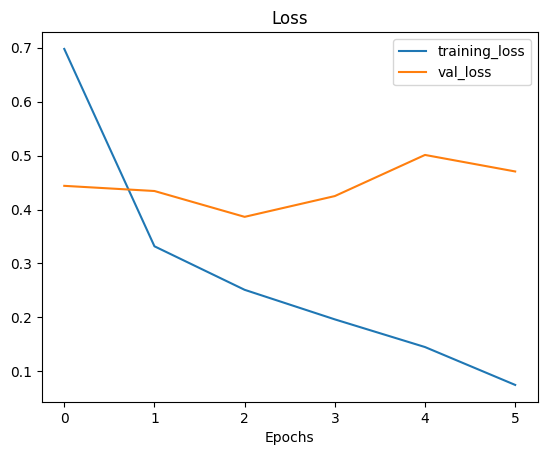

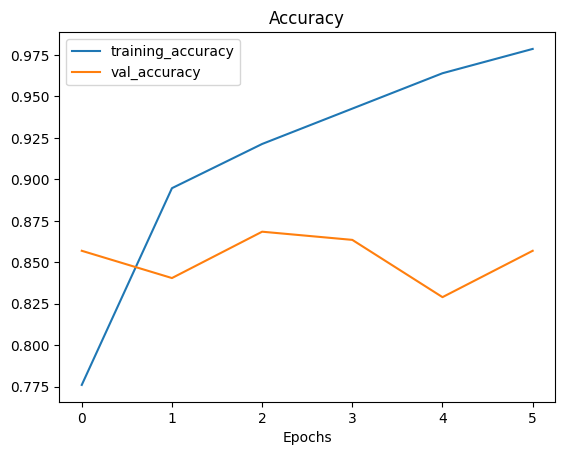

In [ ]:
# Check the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The plot_loss_curves function works great with models which have only been fit once, however, we want     of running `fit()` with another (e.g. before and after fine-tuning).

In [ ]:
# Let's create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  val_total_acc = val_acc + new_history.history["val_accuracy"]
  val_total_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(val_total_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(),
           label="Start Fine Tuning") # reshift plot around
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Accuracy")
  plt.plot(val_total_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(),
           label="Start Fine Tuning") # reshift plot around
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

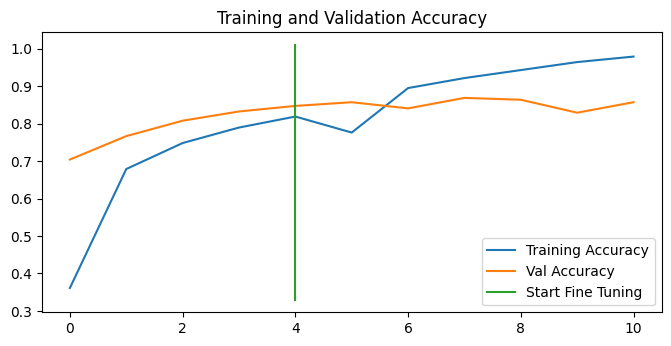

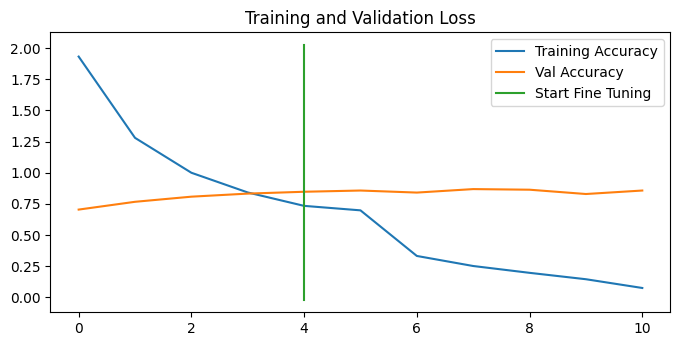

In [ ]:
compare_history(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
!unzip 10_food_classes_all_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: 10_food_classes_all_data/train/hamburger/2119225.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._2119225.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/22923.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._22923.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/3894442.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._3894442.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/1101890.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._1101890.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/2715888.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._2715888.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/554363.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._554363.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/2100953.jpg  
  inf

In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we have loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset)

Let' verify this....

In [ ]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.4782 - accuracy: 0.8564


[0.47823837399482727, 0.8564000129699707]

In [ ]:
results_fine_tune_10_percent

[0.47823837399482727, 0.8564000129699707]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
#  Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned frommodel_2.load_weights(checkpoint_path)
model_2.load_weights(checkpoint_path)

ValueError: Received incompatible tensor with shape (1280, 10) when attempting to restore variable with shape (1, 1, 1152, 48) and name Adam/m/block7a_se_reduce/kernel:0.

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.6180 - accuracy: 0.8424


[0.6179946660995483, 0.8424000144004822]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6179946064949036, 0.8424000144004822]

The previous steps might seem quite confusing but all we have done is:

* 1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
* 2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
* 3. Saved the results and training logs each time.
* 4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_1a")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_1a/20240604-231321
Epoch 5/10
235/235 [==============================] - 107s 418ms/step - loss: 0.6588 - accuracy: 0.7876 - val_loss: 0.3271 - val_accuracy: 0.9046
Epoch 6/10
235/235 [==============================] - 83s 353ms/step - loss: 0.5291 - accuracy: 0.8300 - val_loss: 0.3419 - val_accuracy: 0.8865
Epoch 7/10
235/235 [==============================] - 75s 318ms/step - loss: 0.4781 - accuracy: 0.8501 - val_loss: 0.2996 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 74s 312ms/step - loss: 0.4273 - accuracy: 0.8591 - val_loss: 0.3113 - val_accuracy: 0.8997
Epoch 9/10
235/235 [==============================] - 74s 310ms/step - loss: 0.3919 - accuracy: 0.8747 - val_loss: 0.3019 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 61s 257ms/step - loss: 0.3680 - accuracy: 0.8779 - val_loss: 0.2844 - val_accuracy: 0.9178


In [ ]:
# Let's evaluate on all the data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 68ms/step - loss: 0.2735 - accuracy: 0.9124


[0.2734607458114624, 0.9124000072479248]

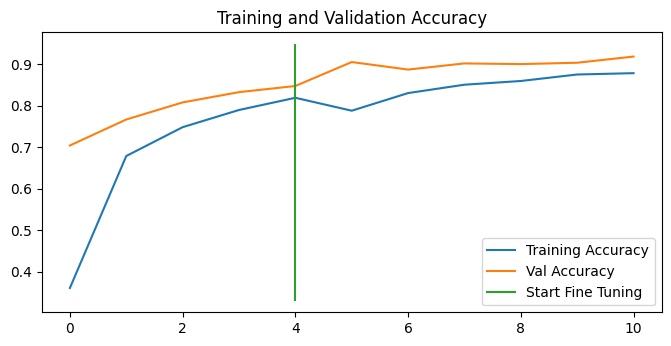

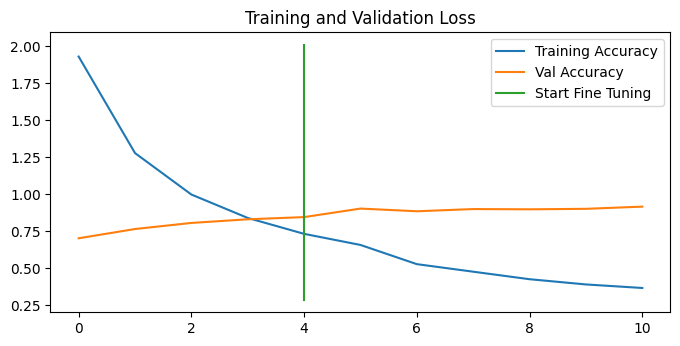

In [ ]:
# How did fine-tuning go with more data?
compare_history(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experimment data on TensorBoard

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

## TensorBoard.dev has been shut down

Comparing our models results using TensorBoard
🔑 Note: When you upload things to tensorboard.dev, you experiments are public. So if you are running private experiments (things you don't want others to see) do not upload them to TensorFlow.dev.

🔑 Note: As of January, 2024, TensorBoard.dev is no longer available. Run %load_ext tensorboard, then %tensorboard --logdir "tensorflow_hub" to achieve the same result.